In [29]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xlrd
import time
import nltk
import seaborn as sns


# Word2Vec function by gensim models

In [19]:
import gensim.models
import logging



def Word2Vec(vector_size,training_alg):
     
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = gensim.models.Word2Vec(size = vector_size,sg=training_alg)
    sentences = gensim.models.word2vec.LineSentence("./corpus/reviews_all_2306.txt")
    model.build_vocab(sentences,total_examples=len(sentences))
    model.train(sentences)

    return model

# Dataset Import Function

In [20]:
def FromExcelToArray():

    WBook = xlrd.open_workbook("./dataset/ReviewsAndRatings_all_19_06.xls")
    WSheets = WBook.sheets()
    ReviewWS,RatingsWS = WSheets


    Ratings = RatingsWS.col_values(0)
    Reviews = ReviewWS.col_values(0)
    Ratings_Normal = RatingsWS.col_values(1)

    return Ratings,Reviews,Ratings_Normal


In [21]:
#Reviews and corresponding rankings are imported from excel
Ratings,Reviews,_ = FromExcelToArray()
sentences = []
for review in Reviews:
    sentences.append(review.split())

# Samples from dataset

In [22]:
for i in range(10):
    ind = np.random.choice(range(np.size(Reviews)))
    print("Review:",Reviews[ind])
    print("Rating:",Ratings[ind])

Review: bence olmamis yani bu kadrodan daha iyi bir sey cikmaliydi muzikal olmasi kesinlikle bi olumsuzluk ben 98 yapimi uma thurman ve liam neeson un oynadigini tercih ederim sahsen 
Rating: 3.5
Review: filmi dun aksam izledim oyunculuk acisindan basarili bir film filmi herkese tavsiye edermiyim veya filmi bir kez daha izlermiyim hic zannetmiyorum 
artik politik drama yakin gecmisin politik kavgalari super kahramanlarin komedi filmleri yapmadigimiz tarzdaki filmerin igrenc komedileri kutsal damacana  halka mesaj vermeye calisan turk filmeri gibi artik insanlarda bikkinlik belirtisi meydana getiren ayni tarz filmer  
unutmayin ki icek abbas disinda yonetmenlik basarisi pek olmayan ve hatta plajda filmi gibi 5 sinif komedi filmin yapimcisi olan sinan cetinin artik kendisini asmasini beklerdim zaten boxoffice listesine baktigim zaman 8 000 kisi tarafindan izlenmis bu film eger sinan cetin gercekten iyi bir yonetmen olmasydi sadece ismi ile 250 000 seyirci cekmesi lazimdi sinemalara 
maal

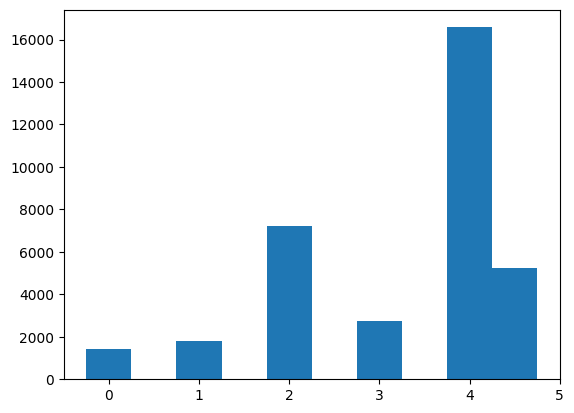

AttributeError: module 'seaborn' has no attribute 'show'

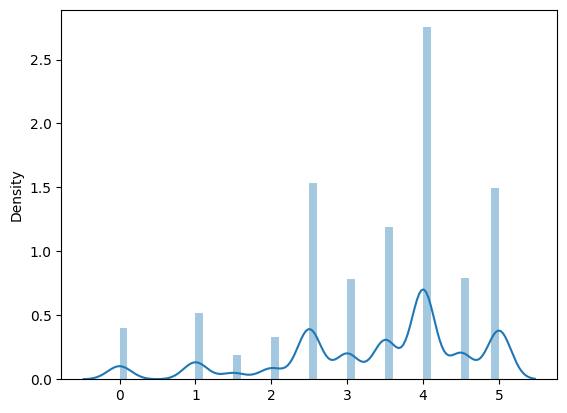

In [32]:
#Ranking distribution of the reviews
plt.hist(np.round(Ratings),align='left');
plt.show()
sns.distplot(Ratings)



<AxesSubplot:ylabel='Count'>

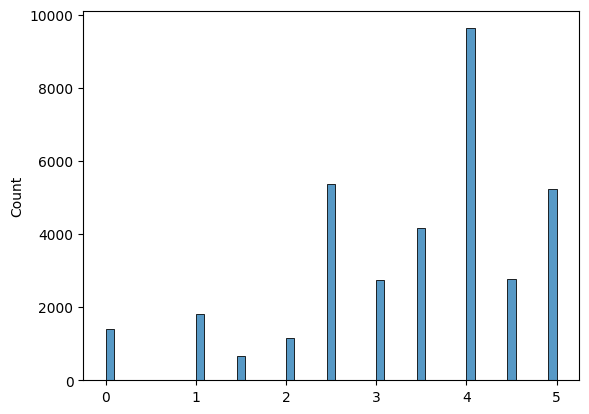

In [33]:
sns.histplot(Ratings)

# W2V Model Generation

A word2vec model is trained with a corpus generated with reviews. To ensure the function of the model, similarities and differences btw randomly selected words are observed.

As expected "harika" and "muthis" have a significant similarity while "berbat" and "harika" have distance in terms of similarity.



- Turkish-English Translation for better understanding:

    harika --> great

    muthis --> awesome

    berbat --> awful

    kotu --> bad

    iyi --> good

    basarili --> successful

    romantik --> romantic

    polisiye --> detective

    turu --> kind

    komedi --> comedy

    muzikal --> musical

In [34]:
model = gensim.models.Word2Vec(sentences)

In [35]:
print(model.similarity("harika","muthis"))
print(model.similarity("berbat","harika"))
print(model.similarity("kotu","berbat"))
print(model.doesnt_match("iyi mukemmel basarili harika berbat".split()))
model.most_similar("romantik")

0.94947255
0.44395068
0.81225914
berbat


[('turu', 0.8496844172477722),
 ('turunde', 0.847367525100708),
 ('fantastik', 0.8393815755844116),
 ('komedisi', 0.8318487405776978),
 ('dram', 0.8307918310165405),
 ('muzikal', 0.8299347162246704),
 ('polisiye', 0.8197457790374756),
 ('komedi', 0.8192417025566101),
 ('komediler', 0.8134389519691467),
 ('macera', 0.7973926663398743)]

# Rev2Vec 

Imported reviews and ratings are processed to convert vector representation. rev2vec is average of vector representation of the review sentences [100 x 1]

In [37]:
rev2vec = np.zeros((100,34900))
rat2vec = np.zeros((1,34900))
temp = np.zeros((100,1))
count = 1

for sentence in sentences:
    vectorSize = 0
    for word in sentence:
        try:
            temp += np.reshape(model[word],(100,1))
            vectorSize += 1
        except KeyError:
            continue
    if vectorSize > 0:
        temp /= vectorSize
        rev2vec[:,count-1:count] = temp
        rat2vec[:,count-1:count] = Ratings[count-1]
        count += 1

# Classification for Ranking Prediction





- Input : 1x100 vector representation of review sentences
- Output: one of the 6 different ranking classes (0,1,2,3,4,5). Half points are rounded up.


As observed SVC has better performance with randomly selected small batch of training set. As training set is getting larger its performance is decreasing. 


Also different kernel (rbf and linear) performance is observed in SVC.

Just for curiosity MLP is also trained and the performance was similar to SVC's. However in terms of computation time there is a significant difference. As number of sample increases computational cost of SVC increase exponentially.

Best performance with 12k random subset:

- SVC Training  : Accuracy: 0.511  computation time : 22.58 sec


- MLP Training  : Accuracy: 0.493  computation time : 1.25 sec

Best performance with all dataset:

- SVC Training  : Accuracy: 0.472 computation time : 269.02 sec

- Linear SVC : Accuracy: 0.462  computation time : 84.44 sec

- MLP Training  : Accuracy: 0.493  computation time : 3.05 sec


## Classification of random subset(12k sample) of the dataset. Data order is random so it is not necessary to generate random index.


In [38]:
#Test/train set division

train_rev = rev2vec.T[:10000,:]
train_rat = rat2vec.T[:10000,:]
test_rev = rev2vec.T[10000:12000,:]
test_rat = rat2vec.T[10000:12000,:]

In [41]:
time_start = time.process_time()

svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(train_rev,np.round(train_rat))
score = svm_model.score(test_rev,np.round(test_rat))

time_elapsed = (time.process_time()- time_start)

print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.5255  computation time : 9.234375


In [70]:
time_start = time.process_time()

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 50,1), random_state=1)
clf.fit(train_rev,np.round(train_rat))
score = clf.score(test_rev,np.round(test_rat))

time_elapsed = (time.process_time()  - time_start)

print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.493  computation time : 1.2507469999998193


## Classification of all of the dataset(~35k sample). 

In [42]:
train_rev,test_rev,train_rat,test_rat = cross_validation.train_test_split(rev2vec.T,rat2vec.T,test_size = 0.2)

NameError: name 'cross_validation' is not defined

In [62]:
#SVC with RBF kernel

time_start = time.process_time()

svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(train_rev,np.round(train_rat))
score = svm_model.score(test_rev,np.round(test_rat))

time_elapsed = (time.process_time()  - time_start)

print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.4722063037249284  computation time : 289.11797


In [65]:
#SVC with linear kernel

time_start = time.process_time() 

svm_model2 = svm.SVC(kernel = 'linear')
svm_model2.fit(train_rev,np.round(train_rat))
score2 = svm_model2.score(test_rev,np.round(test_rat))

time_elapsed = (time.process_time()  - time_start)
print("Accuracy: " + str(score2) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.4722063037249284  computation time : 269.0225969999999


In [77]:
#Linear SVC

time_start = time.clock()

svm_model3 = svm.LinearSVC()
svm_model3.fit(train_rev,np.round(train_rat))
score3 = svm_model3.score(test_rev,np.round(test_rat))

time_elapsed = (time.clock() - time_start)
print("Accuracy: " + str(score3) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.46232091690544413  computation time : 84.44622100000015


In [75]:
time_start = time.clock()

clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(100, 50,1), random_state=1)
clf.fit(train_rev,np.round(train_rat))
clf.score(test_rev,np.round(test_rat))

time_elapsed = (time.clock() - time_start)

print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.493  computation time : 3.0543840000000273


# Classification for Sentiment Prediction


Input : 1x100 vector representation of review sentences
Output: one of the 2 different sentiment classes positive(1) and negative(0). 


Ranking which are greater than 2.5 is considered as positive review while others considered as negative. 

Best performance with 12k random subset:

- SVC Training  : Accuracy: 0.7545  computation time : 14.04

- Linear SVC  Training  : Accuracy: 0.756  computation time : 4.80

- MLP Training  : Accuracy: 0.7495  computation time : 10.25

Best performance with all dataset:

- SVC Training RBF kernel : Accuracy: 0.701  computation time : 196.87 sec

- Linear SVC Training : Accuracy: 0.7  computation time : 15.04 sec

- MLP Training  : Accuracy: 0.687  computation time : 20.38 sec

## Classification of all of the dataset(~35k sample).

In [78]:
#Rating greater than 2.5 is assigned to positive (1), others to negative(0)

rat2vec = np.reshape(rat2vec,(34900))
y = rat2vec
y[rat2vec <= 2.5] = 0
y[rat2vec > 2.5] = 1

In [44]:
train_rev,test_rev,train_rat,test_rat = train_test_split.train_test_split(rev2vec.T,y,test_size = 0.2)


NameError: name 'y' is not defined

In [80]:
time_start = time.clock()

svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(train_rev,train_rat)
score = svm_model.score(test_rev,test_rat)

time_elapsed = (time.clock() - time_start)
print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.7012893982808023  computation time : 196.87777700000015


In [81]:
time_start = time.clock()

svm_model2 = svm.LinearSVC()
svm_model2.fit(train_rev,np.round(train_rat))
score = svm_model2.score(test_rev,np.round(test_rat))

time_elapsed = (time.clock() - time_start)
print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.7  computation time : 15.04471999999987


In [85]:
time_start = time.clock()

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50,5), random_state=1)
clf.fit(train_rev,np.round(train_rat))
score = clf.score(test_rev,np.round(test_rat))

time_elapsed = (time.clock() - time_start)
print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.6876790830945558  computation time : 20.381222999999864


## Classification of random subset(12k sample) of the dataset

In [86]:
train_rev = rev2vec.T[:10000,:]
train_rat = y[:10000]
test_rev = rev2vec.T[10000:12000,:]
test_rat = y[10000:12000]

In [87]:
time_start = time.clock()

svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(train_rev,train_rat)
score = svm_model.score(test_rev,test_rat)

time_elapsed = (time.clock() - time_start)
print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.7545  computation time : 14.048001999999997


In [88]:
time_start = time.clock()

svm_model2 = svm.LinearSVC()
svm_model2.fit(train_rev,np.round(train_rat))
score = svm_model2.score(test_rev,np.round(test_rat))

time_elapsed = (time.clock() - time_start)
print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

Accuracy: 0.756  computation time : 4.809541000000081


In [36]:
time_start = time.clock()

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(50,10,2), random_state=1)
clf.fit(train_rev,np.round(train_rat))
score = clf.score(test_rev,np.round(test_rat))

time_elapsed = (time.clock() - time_start)
print("Accuracy: " + str(score) + " " + " computation time : " + str(time_elapsed))

AttributeError: module 'time' has no attribute 'clock'